In [1]:
import os
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-08-07 13:50:25.113595: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 13:50:25.690545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 76382 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


In [2]:
# import data
import os
import numpy as np
gpath = "/home/abhijit/anik/datasets/tf-qdata/all_preds/"
print(os.path.exists(gpath))
X_train = np.load(gpath + "xtrain.npy")
X_test = np.load(gpath + "xtest.npy")
X_valid = np.load(gpath + "xvalid.npy")

y_train = np.load(gpath + "ytrain.npy")
y_test = np.load(gpath + "ytest.npy")
y_valid = np.load(gpath + "yvalid.npy")

True


In [3]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections
from functools import reduce

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
from cirq.circuits import InsertStrategy

In [4]:
def single_rot_rx(params, qubits):
    # params = list(params)
    ckt = [cirq.rx(params[i]).on(qubits[i]) for i in range(len(qubits))]
    return ckt

def single_rot_rz(params, qubits):
    ckt = [cirq.ry(params[i]).on(qubits[i]) for i in range(len(qubits))]
    return ckt

In [5]:
def do_entangle(params, qubits, idx):
    
    nums = [i for i in range(len(qubits)) if i != idx]
    # print(nums)
    ckt = [cirq.rz(params[i]).on(qubits[nums[i]]).controlled_by(qubits[idx]) for i in range(len(nums))]
    ckt += [cirq.rz(params[-1]).on(qubits[idx])]
    return ckt

def do_entangle_ry(params, qubits, idx):
    
    nums = [i for i in range(len(qubits)) if i != idx]
    # print(nums)
    ckt = [cirq.ry(params[i]).on(qubits[nums[i]]).controlled_by(qubits[idx]) for i in range(len(nums))]
    ckt += [cirq.ry(params[-1]).on(qubits[idx])]
    return ckt

In [6]:
def return_circuit(qubits, n_layers=5):
    n_qubits = len(qubits)
    # params = sympy.symbols(f'T:{2*(n_layers+1)*n_qubits})')
    params = sympy.symbols(f'T:{n_layers*504}')
    params = np.asarray(params).reshape((n_layers, 42, n_qubits))

    # params2 = sympy.symbols(f'T:180')
    # params2 = np.asarray(params2)


    # inputs = sympy.symbols(f'I:{n_layers*n_qubits}')
    # inputs = np.asarray(inputs).reshape((n_layers, n_qubits))
    ckt = cirq.Circuit()
    for l in range(n_layers):
        
        ckt.append(single_rot_rx(params[l, 0, :], qubits), strategy=InsertStrategy.INLINE)
        ckt.append(single_rot_rz(params[l, 1, :], qubits), strategy=InsertStrategy.INLINE)
        start = 2
        for j in range(11, -1, -1):
            ckt.append(do_entangle(params[l, start,:], qubits, j), strategy=InsertStrategy.NEW)
            start += 1 
        # ckt.append(single_rot_rx(inputs[l, :], qubits), strategy=InsertStrategy.INLINE)
        ckt.append(single_rot_rx(params[l, 14, :], qubits), strategy=InsertStrategy.INLINE)
        ckt.append(single_rot_rz(params[l, 15, :], qubits), strategy=InsertStrategy.INLINE)
        go = 16
        for j in range(11, -1, -1):
            ckt.append(do_entangle_ry(params[l, go,:], qubits, j), strategy=InsertStrategy.NEW)
            go += 1 
        ckt.append(single_rot_rx(params[l, 28, :], qubits), strategy=InsertStrategy.INLINE)
        ckt.append(single_rot_rz(params[l, 29, :], qubits), strategy=InsertStrategy.INLINE)
        s = 30
        for j in range(11, -1, -1):
            ckt.append(do_entangle_ry(params[l, s,:], qubits, j), strategy=InsertStrategy.NEW)
            s += 1 
    

    # return ckt, list(params.flat), list(inputs.flat)
    return ckt

In [7]:
def cluster_state_circuit(bits):
    """Return a cluster state on the qubits in `bits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

In [8]:
# Create our qubits and readout operators in Cirq.
cluster_state_bits = cirq.GridQubit.rect(1, 12)
readout_operators = [cirq.Z(q) for q in cluster_state_bits]

In [9]:
# Build a sequential model enacting the logic in 1.3 of this notebook.
# Here you are making the static cluster state prep as a part of the AddCircuit and the
# "quantum datapoints" are coming in the form of excitation
excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
cluster_state = tfq.layers.AddCircuit()(
    excitation_input, append=cluster_state_circuit(cluster_state_bits))

quantum_model = tfq.layers.PQC(return_circuit(cluster_state_bits),
                               readout_operators)(cluster_state)
fc1 = tf.keras.layers.Dense(64, activation='relu')(quantum_model)
drop1 = tf.keras.layers.Dropout(0.5)(fc1)
output = tf.keras.layers.Dense(3, activation='softmax')(drop1)
qcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[output])

In [10]:
tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [11]:
qcnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 add_circuit (AddCircuit)    (None,)                   0         
                                                                 
 pqc (PQC)                   (None, 12)                2520      
                                                                 
 dense (Dense)               (None, 64)                832       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 3,547
Trainable params: 3,547
Non-trainable par

In [12]:
def encode_data(data):
    qubits = cirq.GridQubit.rect(1, 12)
    circuit = cirq.Circuit()

    for i, value in enumerate(data):
        circuit.append(cirq.ry(value).on(qubits[i]))

    return circuit


x_train_enc = [encode_data(x) for x in X_train]
x_test_enc = [encode_data(x) for x in X_test]
x_valid_enc = [encode_data(x) for x in X_valid]

In [13]:
x_train_cirq = tfq.convert_to_tensor(x_train_enc)
x_valid_cirq = tfq.convert_to_tensor(x_valid_enc)
x_test_cirq = tfq.convert_to_tensor(x_test_enc)

In [14]:
qcnn_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [15]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6,
                                            restore_best_weights=True,
                                            mode='auto')

In [16]:
history = qcnn_model.fit(x_train_cirq,
                    y_train,
                    batch_size = 128,
                    epochs = 200,
                    verbose = 1,
                    validation_data = (x_valid_cirq, y_valid),
                    callbacks = [early_stop])

Epoch 1/200


2023-08-02 10:52:22.597259: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


37/37 [==============================] - 373s 10s/step - loss: 1.0095 - categorical_accuracy: 0.6499 - val_loss: 0.8880 - val_categorical_accuracy: 0.6640
Epoch 2/200
37/37 [==============================] - 340s 9s/step - loss: 0.7805 - categorical_accuracy: 0.6647 - val_loss: 0.6748 - val_categorical_accuracy: 0.6640
Epoch 3/200
37/37 [==============================] - 342s 9s/step - loss: 0.5768 - categorical_accuracy: 0.7597 - val_loss: 0.4966 - val_categorical_accuracy: 0.8320
Epoch 4/200
37/37 [==============================] - 341s 9s/step - loss: 0.4053 - categorical_accuracy: 0.8861 - val_loss: 0.3658 - val_categorical_accuracy: 0.8780
Epoch 5/200
37/37 [==============================] - 338s 9s/step - loss: 0.2864 - categorical_accuracy: 0.9005 - val_loss: 0.2845 - val_categorical_accuracy: 0.8780
Epoch 6/200
37/37 [==============================] - 340s 9s/step - loss: 0.2058 - categorical_accuracy: 0.9438 - val_loss: 0.2214 - val_categorical_accuracy: 0.9540
Epoch 7/200
37/

Performance parameters and graph for hybrid-qnn
Accuracy - Train: 0.998, Test: 0.963 
Loss - Train: 0.016, Test: 0.162 



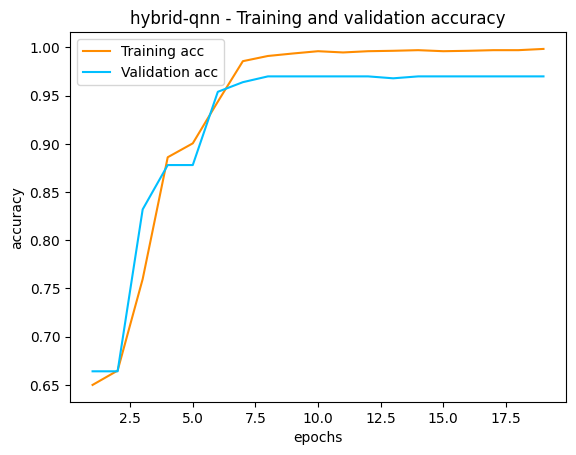

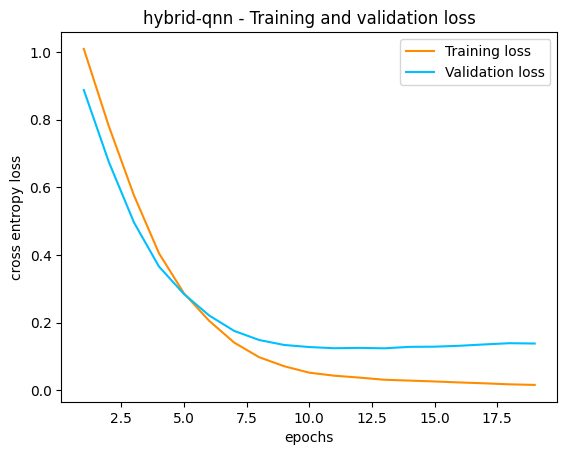

In [17]:
import matplotlib.pyplot as plt

def evaluate_and_plot(model, history, name, flag=False):
    print(f"Performance parameters and graph for {name}")
    # evaluate the model

    train_loss, train_acc =  model.evaluate(x_train_cirq, y_train, verbose=0)
    test_loss, test_acc = model.evaluate(x_test_cirq, y_test, verbose=0)
    print('Accuracy - Train: %.3f, Test: %.3f ' % (train_acc, test_acc))
    print('Loss - Train: %.3f, Test: %.3f \n' % (train_loss, test_loss))
    # learning curves of model accuracy
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, "darkorange", label='Training acc')
    plt.plot(epochs, val_acc, "deepskyblue", label='Validation acc')
    plt.title(f'{name} - Training and validation accuracy')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

    plt.plot(epochs, loss, 'darkorange', label='Training loss')
    plt.plot(epochs, val_loss, 'deepskyblue', label='Validation loss')
    plt.title(f'{name} - Training and validation loss')
    plt.xlabel("epochs")
    plt.ylabel("cross entropy loss")
    plt.legend()
    plt.show()

evaluate_and_plot(qcnn_model, history, "hybrid-qnn")